In [1]:
### JUPYTER NOTEBOOK / MODULE PATH FIX ###
import sys

if "/share/apps/python/3.8.6/intel/lib/python3.8" in sys.path and sys.path[1] == '':
    sys.path[1], sys.path[6] = sys.path[6], sys.path[1]

In [2]:
from jtb_2022_code.utils.figure_common import *
from jtb_2022_code.utils.adata_common import *
from jtb_2022_code.utils.pseudotime_common import do_pca_pt, spearman_rho_pools, spearman_rho_grid, do_denoised_pca
from jtb_2022_code import FigureSingleCellData

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
from scipy.stats import spearmanr

In [3]:
## LOAD AND PROCESS UMAP FOR UMAP PANELS ###
data = FigureSingleCellData()
data.do_projections()
data.apply_inplace_to_everything(do_pca_pt)
data.apply_inplace_to_expts(do_denoised_pca, max(N_PCS))
data.apply_inplace_to_expts(do_pca_pt, pca_key="denoised_pca", pt_key="denoised_pca_pt")
#data.save()

Reading Single Cell Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_1_WT.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_1_fpr1.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_2_WT.h5ad
Reading Single Cell Experiment Data from /scratch/cj59/RAPA/2021_RAPA_TIMECOURSE_FIGS_2_fpr1.h5ad
Applying do_pca_pt to data [['1' '2'], ['WT' 'fpr1']] (173347, 5747)
Applying do_pca_pt to data [['1'], ['WT']] (63533, 5747)
Applying do_pca_pt to data [['1'], ['fpr1']] (4933, 5747)
Applying do_pca_pt to data [['2'], ['WT']] (98996, 5747)
Applying do_pca_pt to data [['2'], ['fpr1']] (5885, 5747)
Applying do_denoised_pca to data [['1'], ['WT']] (63533, 5747)
Applying do_denoised_pca to data [['1'], ['fpr1']] (4933, 5747)
Applying do_denoised_pca to data [['2'], ['WT']] (98996, 5747)
Applying do_denoised_pca to data [['2'], ['

In [4]:
#f = pd.read_csv(PSEUDOTIME_FILES[('dpt', False)], sep="\t", index_col=0)
data.load_pseudotime()
spearman_rho_grid(data, ('dpt', False), 'dpt_rho')
spearman_rho_grid(data, ('cellrank', False), 'cellrank_rho')
spearman_rho_grid(data, ('monocle', False), 'monocle_rho')

Applying _calc_rhos to data [['1'], ['WT']] (63533, 5747)
Applying _calc_rhos to data [['1'], ['fpr1']] (4933, 5747)
Applying _calc_rhos to data [['2'], ['WT']] (98996, 5747)
Applying _calc_rhos to data [['2'], ['fpr1']] (5885, 5747)
Applying _calc_rhos to data [['1'], ['WT']] (63533, 5747)
Applying _calc_rhos to data [['1'], ['fpr1']] (4933, 5747)
Applying _calc_rhos to data [['2'], ['WT']] (98996, 5747)
Applying _calc_rhos to data [['2'], ['fpr1']] (5885, 5747)
Applying _calc_rhos to data [['1'], ['WT']] (63533, 5747)
Applying _calc_rhos to data [['1'], ['fpr1']] (4933, 5747)
Applying _calc_rhos to data [['2'], ['WT']] (98996, 5747)
Applying _calc_rhos to data [['2'], ['fpr1']] (5885, 5747)


In [14]:
np.isinf(data.all_data.obsm[('monocle', False)]).sum(axis=0).sort_values()

5_15       0
25_85      0
15_85      0
5_85       0
105_75     0
          ..
95_35      0
85_35      0
75_35      0
75_45      0
105_105    0
Length: 110, dtype: int64

In [5]:
data.all_data.uns['monocle_rho']

PCs               5        15        25        35        45        55  \
Neighbors        15        15        15        15        15        15   
1 WT       0.865968  0.738167  0.405371  0.545885  0.777495  0.563729   
  fpr1    -0.043481  0.068634  0.190878  0.032448  0.132716  0.158131   
2 WT       0.861577  0.829021  0.857642  0.835690  0.842561  0.847940   
  fpr1     0.143976  0.260381  0.114551  0.454167  0.606487  0.435651   

PCs              65        75        85        95  ...        15        25  \
Neighbors        15        15        15        15  ...       105       105   
1 WT       0.816665  0.792684  0.743031  0.778000  ...  0.774718  0.492332   
  fpr1     0.123659  0.210514  0.113897  0.113929  ...  0.077483  0.007156   
2 WT       0.854387  0.849900  0.825423  0.826023  ...  0.826126  0.824622   
  fpr1     0.446957  0.563112  0.348040  0.494367  ...  0.530501  0.371046   

PCs              35        45        55        65        75        85  \
Neighbors       105       105       105       105       105       105   
1 WT       0.718888  0.770687  0.862218  0.753250  0.789483  0.833967   
  fpr1     0.109895  0.063616  0.059625  0.013757  0.046270  0.066367   
2 WT       0.857287  0.856933  0.842875  0.856254  0.855986  0.858042   
  fpr1     0.322708  0.187591  0.209011  0.475123  0.268794  0.371678   

PCs              95       105  
Neighbors       105       105  
1 WT       0.778227  0.862750  
  fpr1     0.077893  0.145482  
2 WT       0.856958  0.818025  
  fpr1     0.298855  0.338410  

[4 rows x 110 columns]

In [15]:
def _pt_rho_heatmap(data, key, expt=1):
    dpt = data.all_data.uns[key].T.unstack().T
    dpt = dpt.reindex(N_PCS.astype(str), axis=1)
    dpt = dpt.reindex(N_NEIGHBORS.astype(str)[::-1], axis=0, level=2) 
    return dpt.loc[(expt, "WT"), :].applymap(np.abs)

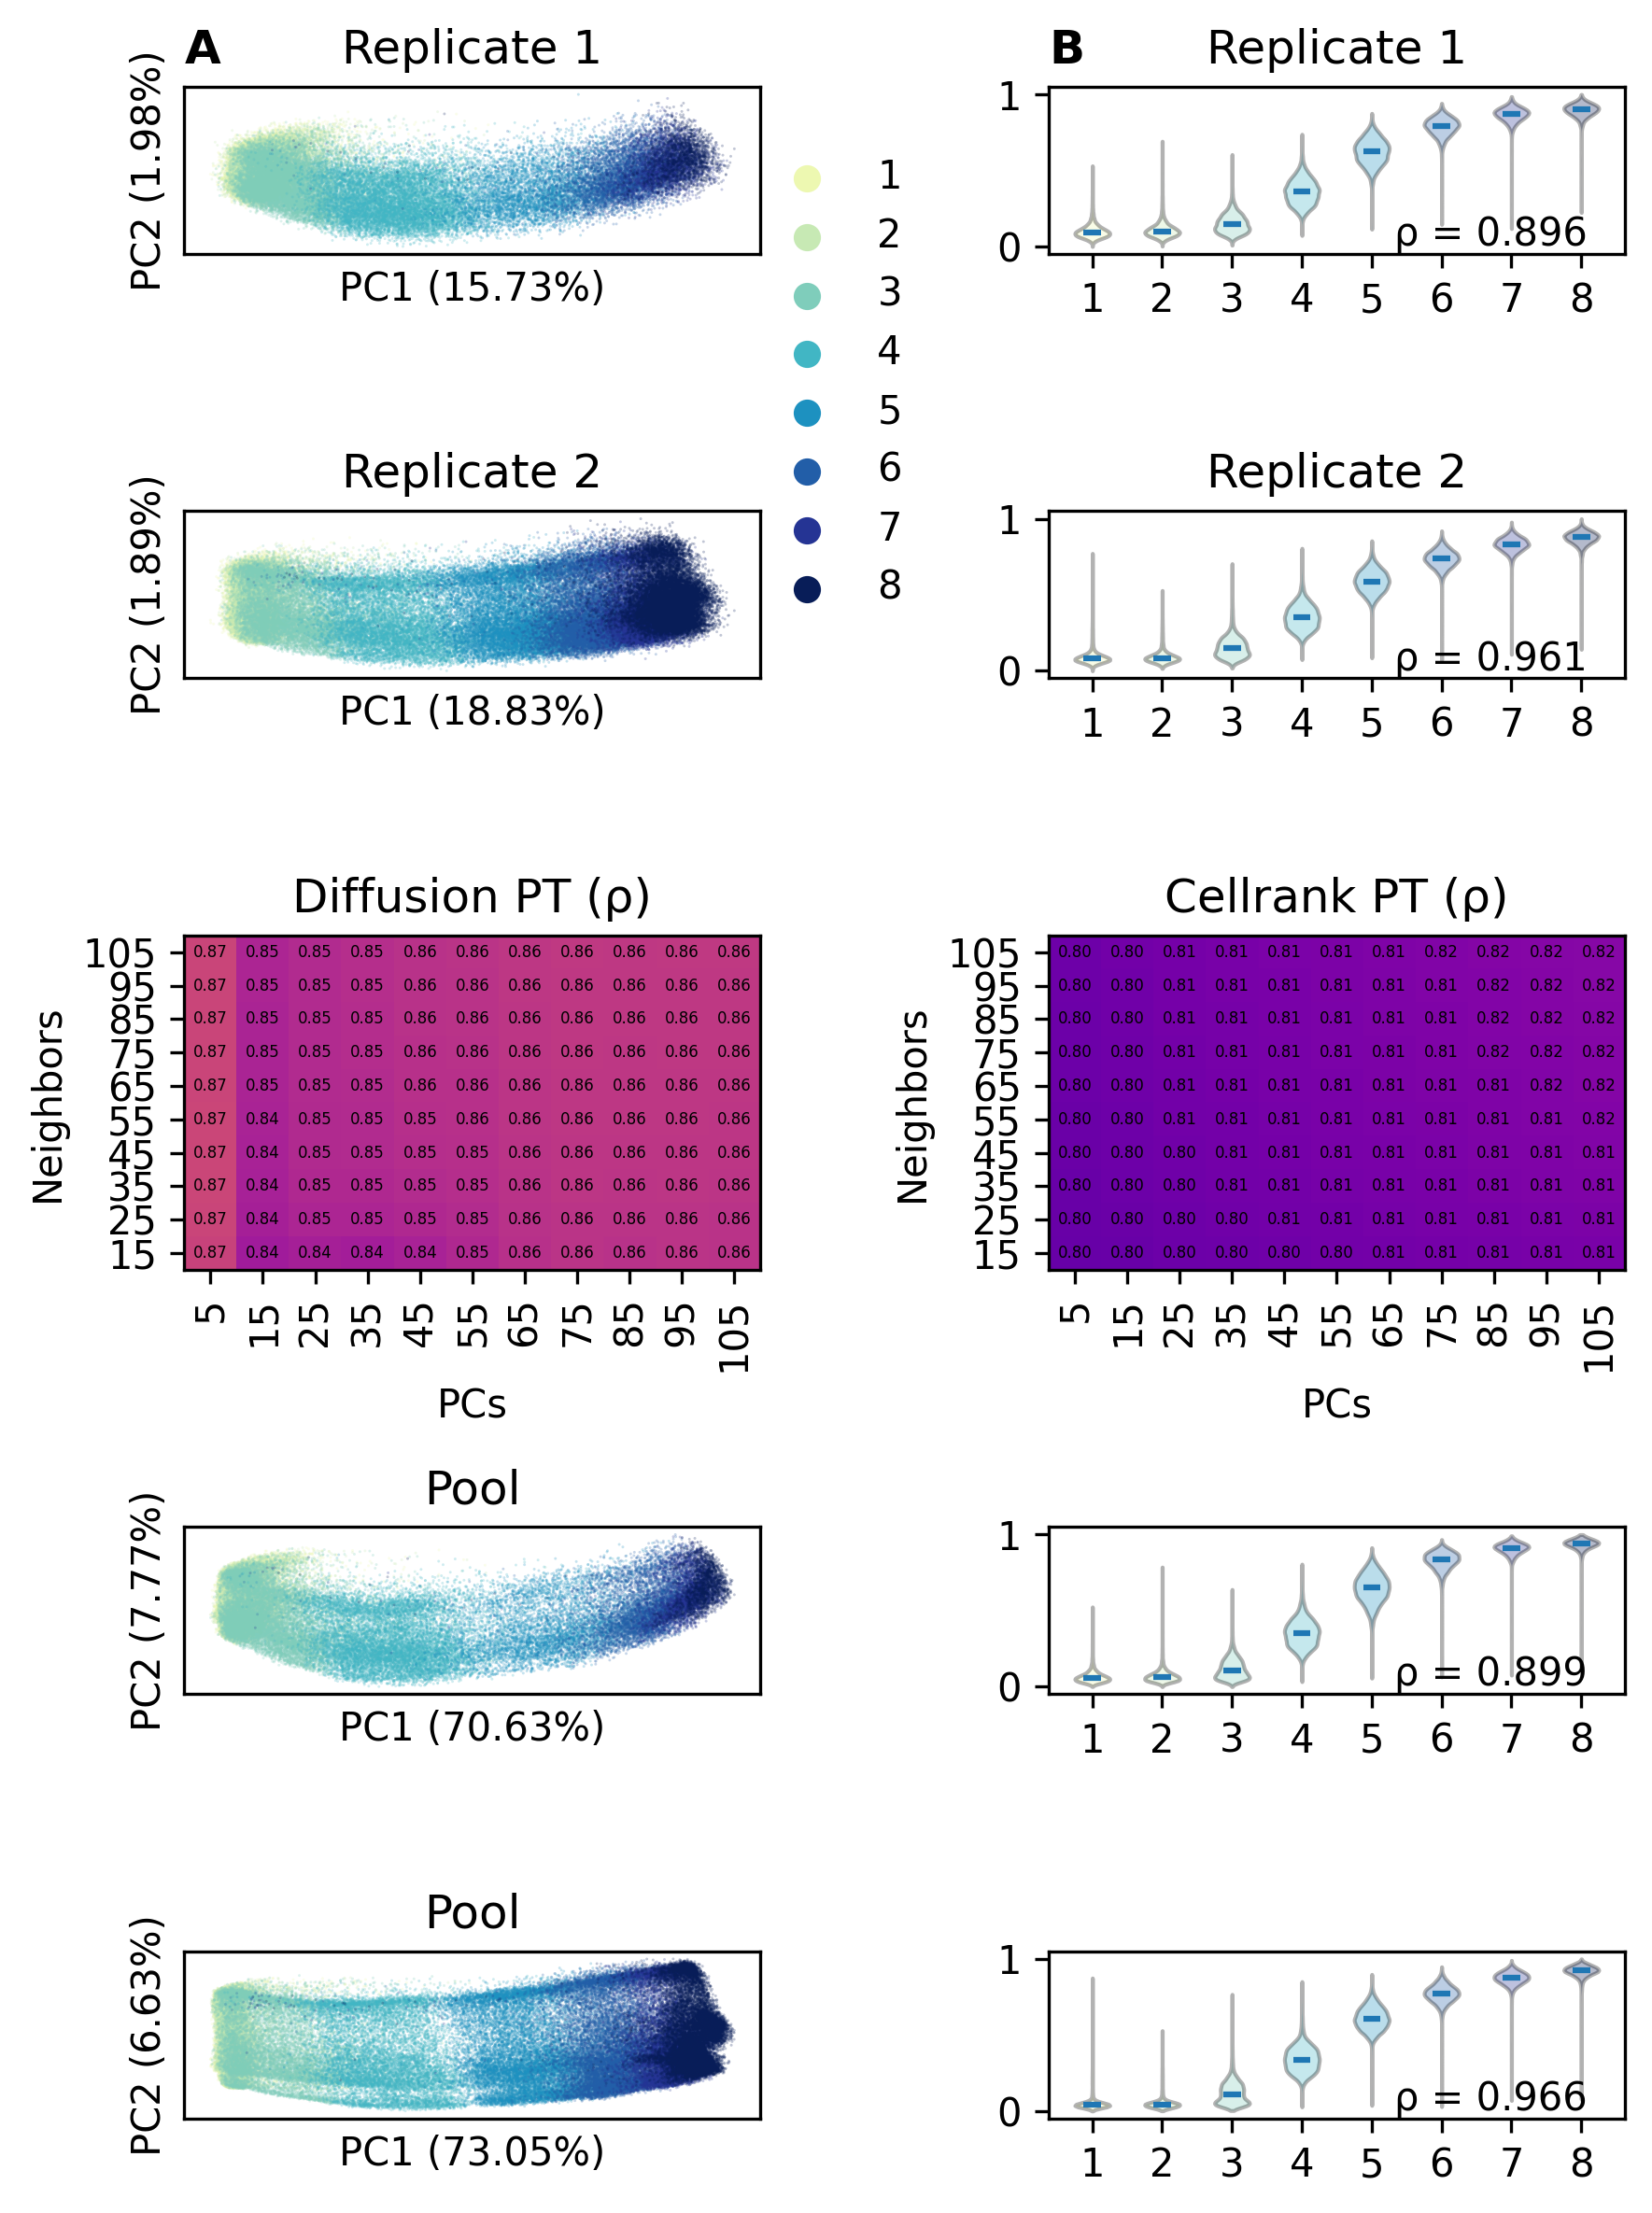

In [17]:
panel_labels = {'pca_1': "A",
                'pca_2': "",
                'pca_pt_1': "B",
                'pca_pt_2': ""}

panel_titles = {'pca_1': "Replicate 1",
                'pca_2': "Replicate 2",
                'pca_pt_1': "Replicate 1",
                'pca_pt_2': "Replicate 2",
                'pca_d1': "Replicate 1",
                'pca_d2': "Replicate 2",
                'pca_pt_d1': "Replicate 1",
                'pca_pt_d2': "Replicate 2",}

layout = [['pca_1', 'pca_lgd', 'pca_pt_1'],
          ['pca_2', 'pca_lgd', 'pca_pt_2'],
          ['pca_d1', 'pca_dlgd', 'pca_pt_d1'],
          ['pca_d2', 'pca_dlgd', 'pca_pt_d2']]

fig_refs = {}

fig, axd = plt.subplot_mosaic(layout,
                              gridspec_kw=dict(width_ratios=[1, 0.5, 1], 
                                               height_ratios=[1, 1, 1, 1],
                                               wspace=0), 
                              figsize=(6, 8), dpi=300)
                              #constrained_layout=True)
plt.subplots_adjust(wspace=0)

axd["pca_lgd"].axis('off')
axd["pca_dlgd"].axis('off')


def _plt_pt_violins(pdata, ax, pt_key):
    pca_pt_data = {k: v[pt_key] for k, v in pdata.obs[[pt_key, 'Pool']].groupby("Pool")}
    ref = ax.violinplot([pca_pt_data[j] for j in range(1,9)], showmeans=False, showmedians=True, showextrema=False)
    ax.set_xticks(np.arange(8) + 1, labels=np.arange(8) + 1)
    
    rho = spearman_rho_pools(pdata.obs['Pool'], pdata.obs[pt_key])
    ax.annotate("ρ = " + f"{rho:.3f}", xy=(5, 0.2),  xycoords='data', xytext=(0.6, 0.05), textcoords='axes fraction')
    
    for part, c in zip(ref['bodies'], pool_palette()):
        part.set_facecolor(c)
        part.set_edgecolor('black')
        
    return ref


for i in range(1,3):
    pca_key = "pca_" + str(i)
    pca_d_key = "pca_d" + str(i)
    
    pt_key = "pca_pt_" + str(i)
    pt_d_key = "pca_pt_d" + str(i)
    
    pca_data = data.expt_data[i, "WT"]
    pca_d_data = get_clean_anndata(pca_data)
    pca_d_data.obsm['X_pca'] = pca_data.obsm['denoised_pca'].copy()
    pca_d_data.uns['pca'] = pca_data.uns['denoised_pca'].copy()
    

    ### PANEL A ###
    fig_refs[pca_key] = sc.pl.pca(pca_data, ax=axd[pca_key], 
                                  color="Pool", palette=pool_palette(), 
                                  show=False, alpha=0.25, size=2, legend_loc='none',
                                  annotate_var_explained=True)
    fig_refs[pca_d_key] = sc.pl.pca(pca_d_data, ax=axd[pca_d_key], 
                                    color="Pool", palette=pool_palette(), 
                                    show=False, alpha=0.25, size=2, legend_loc='none',
                                    annotate_var_explained=True)

    ### PANEL B ###
    fig_refs[pt_key] = _plt_pt_violins(pca_data, axd[pt_key], 'pca_pt')
    fig_refs[pt_d_key] = _plt_pt_violins(pca_d_data, axd[pt_d_key], 'denoised_pca_pt')


    

for pt, pt_key in [('Diffusion PT (ρ)', 'dpt_rho'), ('Cellrank PT (ρ)', 'cellrank_rho')]:
    hm_data = _pt_rho_heatmap(data, pt_key)
    fig_refs[pt_key] = axd[pt_key].imshow(hm_data, vmin=0.75, vmax=1.0,
                                          cmap='plasma', aspect='auto', interpolation='nearest')
    axd[pt_key].set_yticks(range(hm_data.shape[0]), labels=hm_data.index)
    axd[pt_key].set_xticks(range(hm_data.shape[1]), labels=hm_data.columns, rotation=90, ha="center")
    axd[pt_key].set_ylabel("Neighbors")
    axd[pt_key].set_xlabel("PCs") 
    #axd[pt_key].set_xlim(-0.5, hm_data.shape[0] - 0.5)
    #axd[pt_key].set_ylim(-0.5, hm_data.shape[1] - 0.5)
    axd[pt_key].set_title(pt)
    
    # https://stackoverflow.com/questions/11917547/how-to-annotate-heatmap-with-text-in-matplotlib
    for y in range(hm_data.shape[0]):
        for x in range(hm_data.shape[1]):
            axd[pt_key].text(x, y, '%.2f' % hm_data.iloc[y, x], 
                             horizontalalignment='center', 
                             verticalalignment='center',
                             size=4
                     )

fig_refs['pca_legend'] = add_legend(axd['pca_lgd'], 
                                    pool_palette(), 
                                    data.all_data.obs['Pool'].dtype.categories.values)

for ax_id, label in panel_labels.items():
    axd[ax_id].set_title(panel_titles[ax_id])
    axd[ax_id].set_title(label, loc='left', weight='bold')
    
fig.tight_layout()   

In [ ]:
axd[pt_key].get_ylim()

In [ ]:
hm_data